In [1]:
import os
import pandas as pd
import numpy as np
import h5py

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from scipy.sparse import hstack, vstack, csr_matrix
from scipy import sparse

from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Dense, Dropout, merge, concatenate
from keras.layers import LSTM, Embedding, GRU
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.normalization import BatchNormalization
from keras_tqdm import TQDMNotebookCallback, TQDMCallback


from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm import SVC, LinearSVC, NuSVC

from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif, chi2, SelectFromModel
from sklearn.feature_selection import VarianceThreshold

from sklearn import preprocessing
from sklearn.decomposition import PCA

import gensim
from gensim.models import Word2Vec

import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import spacy
from fuzzywuzzy import fuzz

from multiprocessing import Pool

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt

#font = {'family': 'Verdana', 'weight': 'normal'}
#rc('font', **font)
matplotlib.style.use('classic')

%matplotlib inline

pd.set_option('display.max_rows', 15)

In [3]:
def space_tokenizer(s):
    return s.split()

# Загрузка данных

### GoogleNews-vectors-negative300

In [ ]:
w2v_path = os.path.join(os.sep, os.path.abspath('/home/data/word2vec/english/GoogleNews-vectors-negative300.bin'))
w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_path, binary=True)
w2v.init_sims(replace=True)

### Tokenized Data

In [ ]:
def load_tokenized_series(filename):
    try:
        series = pd.read_csv(filename, index_col='id', header=0)
    except:
        series = pd.read_csv(filename, index_col='test_id', header=0)
    series = series['question'].fillna('')
    return series

In [ ]:
# load tokenized questions
train_q1_tokenized_objects = load_tokenized_series('train_q1_tokenized.csv')
train_q2_tokenized_objects = load_tokenized_series('train_q2_tokenized.csv')
test_q1_tokenized_objects = load_tokenized_series('test_q1_tokenized.csv')
test_q2_tokenized_objects = load_tokenized_series('test_q2_tokenized.csv')

In [ ]:
train_set = pd.read_csv('/home/data/share/quora/train.csv', index_col=0)
Y_train = train_set['is_duplicate']
del train_set

#### stopwords removing

In [8]:
is_remove_stopwords = True

stopwords_set = set([stopword for stopword in stopwords.words("english") if stopword not in w2v.vocab])

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords_set])

if is_remove_stopwords:
    train_q1_tokenized_objects = train_q1_tokenized_objects.apply(remove_stopwords)
    train_q2_tokenized_objects = train_q2_tokenized_objects.apply(remove_stopwords)
    test_q1_tokenized_objects = test_q1_tokenized_objects.apply(remove_stopwords)
    test_q2_tokenized_objects = test_q2_tokenized_objects.apply(remove_stopwords)

In [9]:
stopwords_set

{'a', 'and', 'mightn', 'mustn', 'of', 'to'}

## Разделение на пары

In [10]:
train_index = train_q1_tokenized_objects.index
train_pairs = pd.DataFrame(index=train_index)
train_pairs['question1'] = train_q1_tokenized_objects
train_pairs['question2'] = train_q2_tokenized_objects
train_pairs = train_pairs.values

test_index = test_q1_tokenized_objects.index
test_pairs = pd.DataFrame(index=test_index)
test_pairs['question1'] = test_q1_tokenized_objects
test_pairs['question2'] = test_q2_tokenized_objects
test_pairs = test_pairs.values

# Features

## Tokens Sequences

In [11]:
all_texts = np.concatenate([train_pairs[:, 0], train_pairs[:, 1], test_pairs[:, 0], test_pairs[:, 1]])
tokenizer = Tokenizer(filters='', lower=False, split=' ')
tokenizer.fit_on_texts(all_texts)

In [12]:
vocab = tokenizer.word_index
inverse_vocab = {value: key for key, value in vocab.items()}
vocab_len = len(vocab)
print('Found {} unique tokens'.format(vocab_len))

Found 128778 unique tokens


In [13]:
train_sequences = train_pairs.copy()
train_sequences[:, 0] = tokenizer.texts_to_sequences(train_sequences[:, 0])
train_sequences[:, 1] = tokenizer.texts_to_sequences(train_sequences[:, 1])

test_sequences = test_pairs.copy()
test_sequences[:, 0] = tokenizer.texts_to_sequences(test_sequences[:, 0])
test_sequences[:, 1] = tokenizer.texts_to_sequences(test_sequences[:, 1])

In [14]:
def print_len_stats(sequences):
    lens = [len(question) for questions in sequences for question in questions]
    print('Max: {}, Min: {}, Mean: {}, Percentile95: {}'.format(max(lens), min(lens), np.mean(lens), np.percentile(lens, 95)))
    
print_len_stats(train_sequences)
print_len_stats(test_sequences)

Max: 215, Min: 0, Mean: 10.32597269286898, Percentile95: 21.0
Max: 216, Min: 0, Mean: 10.330221170127325, Percentile95: 21.0


In [15]:
maxlen = 21

train_sequences_q1 = pad_sequences(train_sequences[:, 0], maxlen=maxlen)
train_sequences_q2 = pad_sequences(train_sequences[:, 1], maxlen=maxlen)
train_sequences = np.array([pair for pair in list(zip(train_sequences_q1, train_sequences_q2))])
del train_sequences_q1, train_sequences_q2

test_sequences_q1 = pad_sequences(test_sequences[:, 0], maxlen=maxlen)
test_sequences_q2 = pad_sequences(test_sequences[:, 1], maxlen=maxlen)
test_sequences = np.array([pair for pair in list(zip(test_sequences_q1, test_sequences_q2))])
del test_sequences_q1, test_sequences_q2

In [16]:
train_sequences.shape, test_sequences.shape

((404290, 2, 21), (2345796, 2, 21))

## IDF product matrix

In [17]:
def n_containing(word, documents):
    return sum(1 for document in documents if word in document)

def idfs(vocabulary, documents):
    documents = [document.split(' ') for document in documents]
    return {word: math.log(len(documents) / (1 + n_containing(word, documents))) for word in vocabulary}

In [18]:
tfidf_vectorizer = TfidfVectorizer(vocabulary={key: value-1 for key, value in vocab.items()},
                                               tokenizer=space_tokenizer, lowercase=False)
tfidf_vectorizer = tfidf_vectorizer.fit(all_texts)

In [19]:
idfs = {key+1: value for key, value in enumerate(tfidf_vectorizer.idf_)}

max_idf = max(idfs.values())
idfs = {key: value/max_idf for key, value in idfs.items()}

In [20]:
def get_idfs_product_matrix(tokens_q1, tokens_q2):
    matrix = [[np.sqrt(idfs[vocab[token_q1]]*idfs[vocab[token_q2]]) for token_q1 in tokens_q1] for token_q2 in tokens_q2]
    return np.array(matrix)

## Tokens Similarities

In [21]:
def w2v_similarity(token_q1, token_q2):
    similarity = 0
    
    if token_q1 and token_q1:
        if token_q1 in w2v.vocab and token_q2 in w2v.vocab:
            similarity = w2v.similarity(token_q1, token_q2)
        elif token_q1==token_q2:
            similarity = 1
        
    return similarity

def fuzzy_similarity(token_q1, token_q2):
    similarity = 0
    
    if token_q1 and token_q1:
        similarity = fuzz.ratio(token_q1, token_q2)/100
        
    return similarity

def wordnet_similarity(token_q1, token_q2):
    similarity = 0
    
    if token_q1 and token_q1:
        if token_q1==token_q2:
            return 1

        synsets_token_q1 = wordnet.synsets(token_q1)
        synsets_token_q2 = wordnet.synsets(token_q2)

        similaritis = []
        if synsets_token_q1 and synsets_token_q2:
            similaritis = [synset_q1.wup_similarity(synset_q2) 
                           for synset_q1 in synsets_token_q1 
                           for synset_q2 in synsets_token_q2]
            similaritis = [s for s in similaritis if s is not None]

        if similaritis:
            similarity = max(similaritis)
        else:
            similarity = 0
    
    return similarity

### similarity matrixes

In [22]:
def get_similarity_matrix(tokens_q1, tokens_q2, similarity):
    matrix = [[similarity(token_q1, token_q2) for token_q1 in tokens_q1] for token_q2 in tokens_q2]
    
    return np.array(matrix)

def pad_matrix(matrix, maxlen):
    if not matrix.shape[-1]:
        return np.zeros((maxlen, maxlen))
    
    matrix = np.array(matrix)[:maxlen , :maxlen]
    shape = matrix.shape
    width_to_add, height_to_add = (maxlen-shape[0])/2, (maxlen-shape[1])/2
    
    begin_y = int(np.ceil(width_to_add)) if maxlen-shape[0] > 0 else 0
    after_y = int(np.floor(width_to_add)) if maxlen-shape[0] > 0 else 0
    begin_x = int(np.ceil(height_to_add)) if maxlen-shape[1] > 0 else 0
    after_x = int(np.floor(height_to_add)) if maxlen-shape[1] > 0 else 0
    
    pad_width = ((begin_y, after_y), (begin_x, after_x))
    matrix = np.pad(matrix, pad_width, mode='constant')
    
    return matrix

how do you translate the word kill japanese
how is the word help translated in japanese
is duplicate:  0


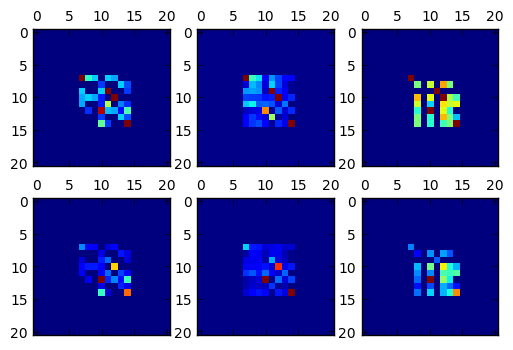

what are some tips write novel
what are some good tips for writing novel
is duplicate:  1


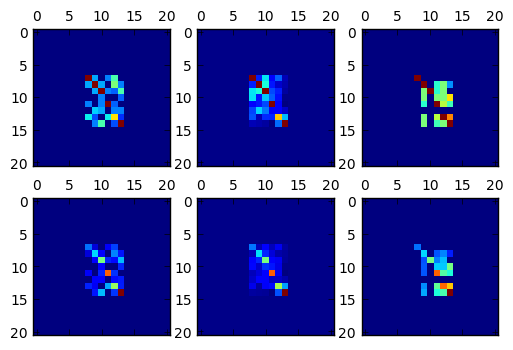

what is the sole purpose our existence
what is our purpose in being here
is duplicate:  1


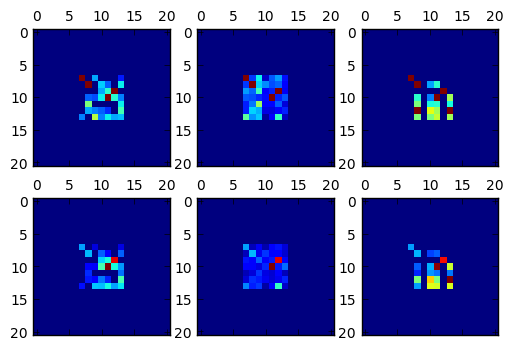

how india can respond the uri terror attack
how should we react on uri camp terror attack
is duplicate:  1


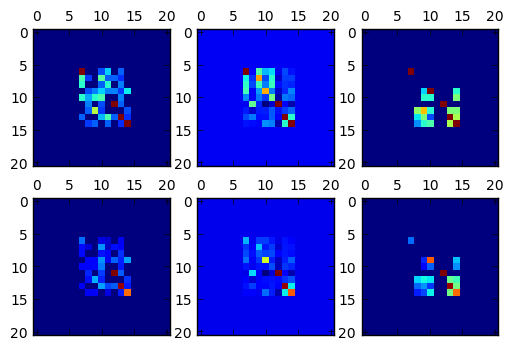

difference between wear friction
how much is alphasights
is duplicate:  0


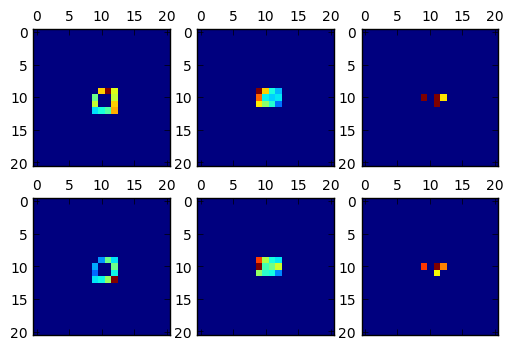

can someone see that i viewed their instagram story if we are not friends
if someone tags my friend in photo on instagram how do i see that photo
is duplicate:  0


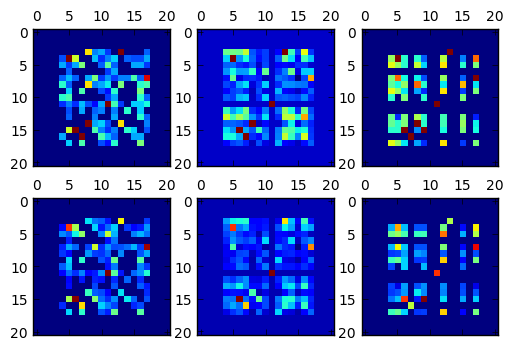

how much money do you earn after 5 years after 10 years after getting starting salary package around 7 lac year after graduation
where do people who get 1 crore package after graduation find themselves after 10 years
is duplicate:  0


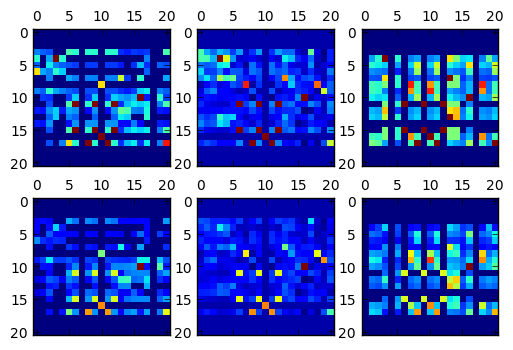

what is the most embarrassing moment that has ever happened you in public area
what is the most embarrassing moment that ever happened you
is duplicate:  1


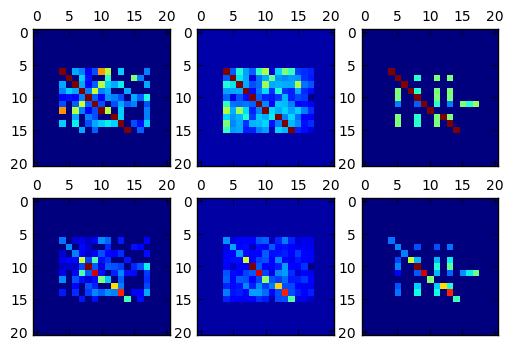

what is the complete function the kidney medulla
what is the function the kidney
is duplicate:  0


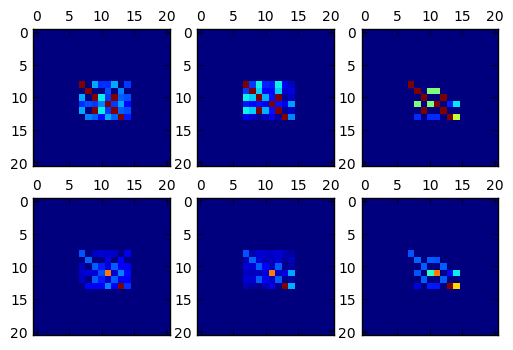

what hotel in biligiri hills hill station would be safe for unmarried couples without the harassment police hotel staff moral police
what hotel in durpin hills hill station would be safe for unmarried couples without the harassment police hotel staff moral police
is duplicate:  0


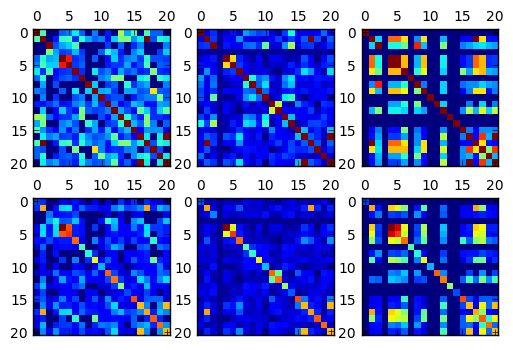

why do women get special treatment
what preferential treatment do women receive that are not usually given men
is duplicate:  0


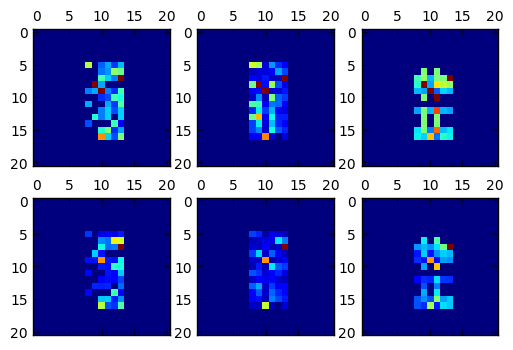

is math 201 higher level math than math 115
is math 201 intro probability statistics higher level math than math 115 mathematics for the liberal arts
is duplicate:  1


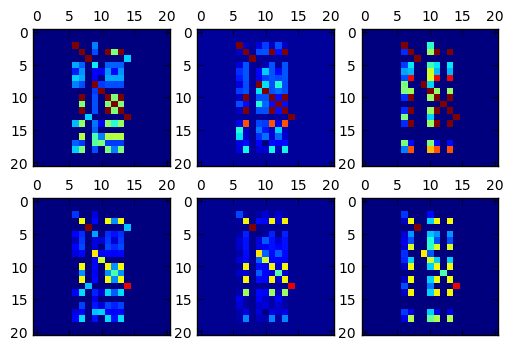

what is ext js used for
ext js why ext js is niche skill
is duplicate:  0


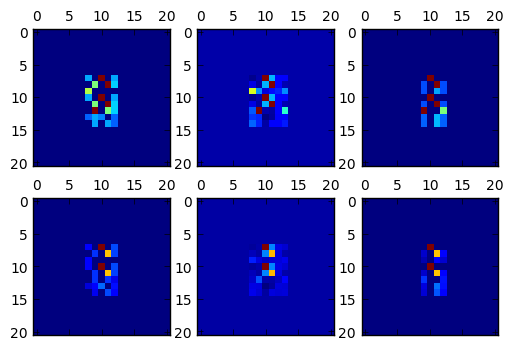

which candidate is currently projected win the 2016 election at this time
who do you think will win the 2016 presidential election
is duplicate:  1


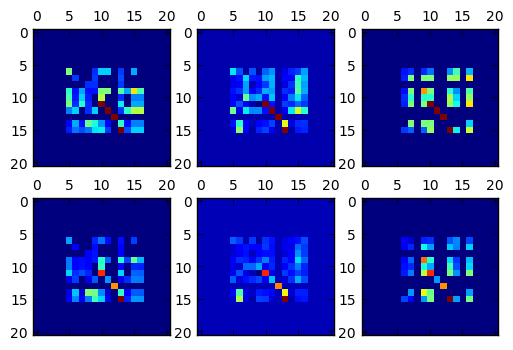

what is the value square root 2
what is the value the square root 1
is duplicate:  0


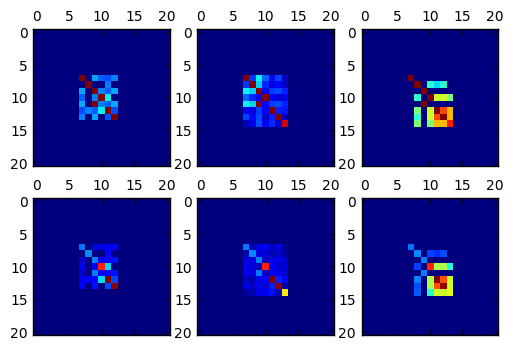

how do i get rid splinters in my foot
how do i get rid multiple tiny splinters on my foot
is duplicate:  0


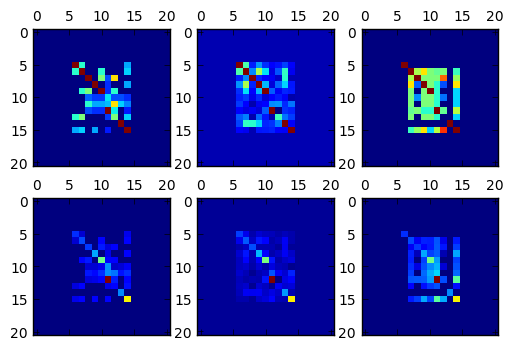

which countries have stealth helicopters
how do helicopters hover
is duplicate:  0


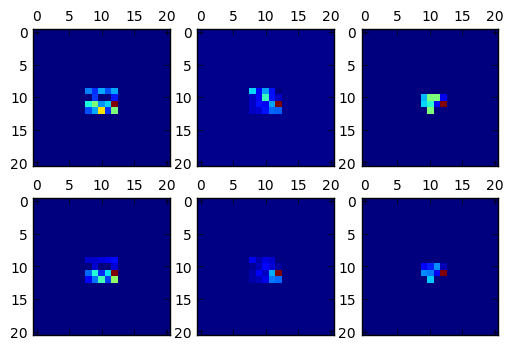

what is the typical career path for someone who becomes professor in journalism
what is the typical career path for someone who becomes professor in history
is duplicate:  0


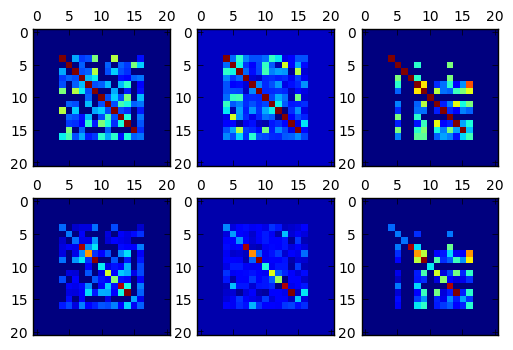

are you allowed bring bikes campus when you live off campus when you are studying at iit bombay
are you allowed have bikes when you live off campus when you are studying at iit bombay
is duplicate:  0


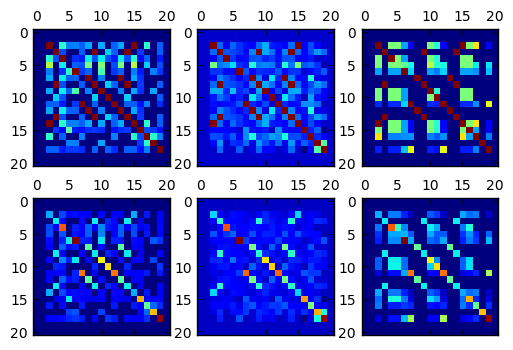

what is the most compelling journal article you have read
which journal is the world most read journal in the area biotechnology
is duplicate:  0


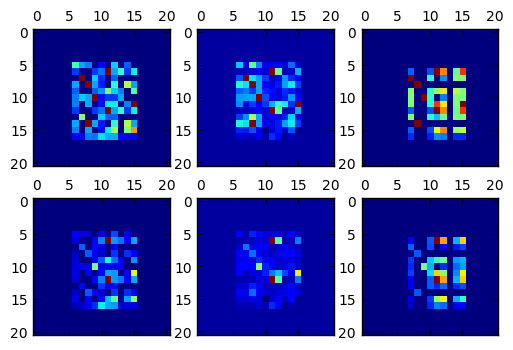

what is the best language for web development
what are the best programming languages learn for web development
is duplicate:  1


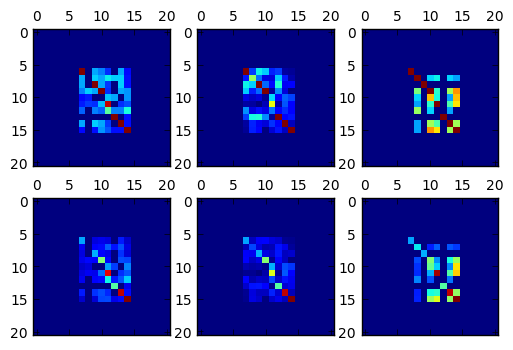

some rothko paintings have significantly changed colour over time why are they not now considered worthless
what is the most significant positive behavioral change you have experienced in yourself over time
is duplicate:  0


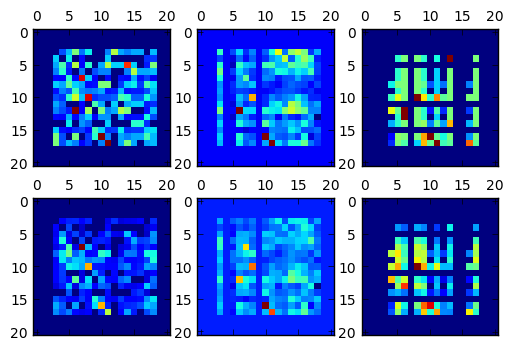

how should i change the name my youtube channel
what should i name my youtube channel
is duplicate:  0


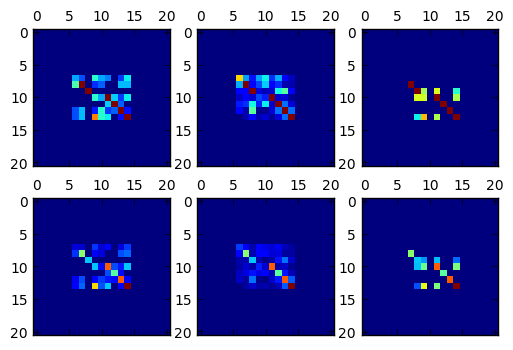

how will trump presidency affect prospective international students from syria
how will donald j trump presidency affect the opportunities offered non us students
is duplicate:  1


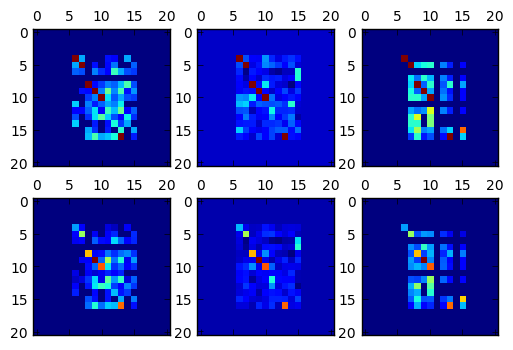

does drinking cups herbal tea count toward the daily water consumption requirement 8 glasses
is good drink 12 cups green tea day
is duplicate:  0


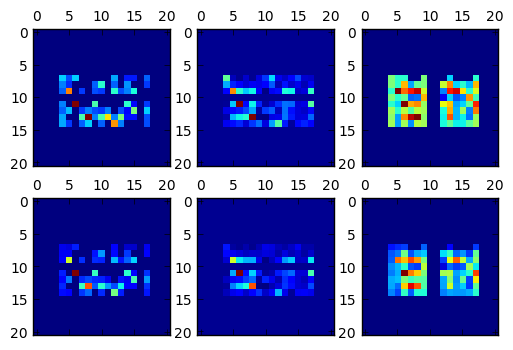

In [23]:
for i in range(25):
    n = np.random.randint(Y_train.shape[0])
    q1, q2 = train_pairs[n]
    idf_m = get_idfs_product_matrix(q1.split(), q2.split())
    
    m1 = get_similarity_matrix(q1.split(), q2.split(), fuzzy_similarity)
    m2 = get_similarity_matrix(q1.split(), q2.split(), w2v_similarity)
    m3 = get_similarity_matrix(q1.split(), q2.split(), wordnet_similarity)
    
    m4 = m1*idf_m
    m5 = m2*idf_m
    m6 = m3*idf_m
    
    print(q1)
    print(q2)
    print('is duplicate: ', Y_train[n])

    fig, axs = plt.subplots(nrows=2, ncols=3)
    axs[0][0].matshow(pad_matrix(m1, maxlen))
    axs[0][1].matshow(pad_matrix(m2, maxlen))
    axs[0][2].matshow(pad_matrix(m3, maxlen))
    axs[1][0].matshow(pad_matrix(m4, maxlen))
    axs[1][1].matshow(pad_matrix(m5, maxlen))
    axs[1][2].matshow(pad_matrix(m6, maxlen))
    plt.show()

In [24]:
def get_all_similarity_matrixes(sequences, maxlen=maxlen):
    s1, s2 = sequences
    q1, q2 = s1.split(), s2.split()
    
    idf_matrix = get_idfs_product_matrix(q1, q2)
    representation_fuzzy = get_similarity_matrix(q1, q2, fuzzy_similarity)
    representation_w2v = get_similarity_matrix(q1, q2, w2v_similarity)
    
    tensor = [pad_matrix(idf_matrix, maxlen), pad_matrix(representation_fuzzy, maxlen), pad_matrix(representation_w2v, maxlen)]
    
    return tensor

def calculate_similarity_matrixes(sequences, maxlen=maxlen):    
    similarity_matrixes = np.zeros((sequences.shape[0], 3, maxlen, maxlen))
    for i, sequence in tqdm.tqdm(enumerate(sequences)):
        tensor = get_all_similarity_matrixes(sequence, maxlen)
        similarity_matrixes[i] = tensor
        
    return similarity_matrixes

## Stoore and Load

In [37]:
if 1==0:
    similarity_matrixes_train = calculate_similarity_matrixes(train_pairs, maxlen)
    similarity_matrixes_test = calculate_similarity_matrixes(test_pairs, maxlen)

    with h5py.File('similarity_matrixes_v2.h5', 'w') as hf:
        hf.create_dataset("similarity_matrixes_train_centred_idf_fuzzy_w2v",  data=similarity_matrixes_train)
        hf.create_dataset("similarity_matrixes_test_centred_idf_fuzzy_w2v",  data=similarity_matrixes_test)

404290it [11:31, 585.07it/s]
2345796it [1:05:53, 593.32it/s]


In [6]:
with h5py.File('similarity_matrixes_v2.h5', 'r') as hf:
    similarity_matrixes_train = hf['similarity_matrixes_train_centred_idf_fuzzy_w2v'][:]
    #similarity_matrixes_test = hf['similarity_matrixes_test_centred_idf_fuzzy_w2v'][:]